# $Telco Project Data$

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import wrangle as w

# to see all columns in wide datasets
pd.set_option('display.max_columns', None)


In [2]:
# acquire telco data 
df = w.get_telco_data()

In [3]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [4]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [5]:
df.shape


(7043, 24)

In [6]:
df.total_charges.value_counts()

           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
2387.75     1
6302.8      1
2058.5      1
829.55      1
3707.6      1
Name: total_charges, Length: 6531, dtype: int64

# prepare

In [7]:
# cleaning data
df = w.prep_telco(df)

In [8]:
df

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_No phone service,multiple_lines_Yes,online_security_No,online_security_No internet service,online_security_Yes,online_backup_No,online_backup_No internet service,online_backup_Yes,device_protection_No,device_protection_No internet service,device_protection_Yes,tech_support_No,tech_support_No internet service,tech_support_Yes,streaming_tv_No,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_No,paperless_billing_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.60,593.30,No,One year,DSL,Mailed check,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.90,542.40,No,Month-to-month,DSL,Mailed check,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.90,267.40,Yes,Month-to-month,Fiber optic,Mailed check,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,Yes,No,No,No,55.15,742.90,No,One year,DSL,Mailed check,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,No,No,Yes,Yes,85.10,1873.70,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0
7040,Male,0,No,No,2,Yes,No,No,Yes,No,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,Yes,No,Yes,No,67.85,4627.65,No,Two year,DSL,Mailed check,0,1,0,1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1



df[df.contract_type != 'Month-to-month']

In [9]:
df.shape

(7032, 61)

In [10]:
def split_telco_data(df):
    '''
    This function split telco data into train , validate, test and  stratifies on churn.
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    Returns train, validate, and test 
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [11]:
# split data
train, validate, test = split_telco_data(df)
train.shape,validate.shape, test.shape



((3937, 61), (1688, 61), (1407, 61))

# plt.title('Churn Mean')
sns.barplot(x=len(train.churn_Yes), y = train.churn_Yes., data = train,ci=False,saturation=.9, palette="PuRd_r")
col_mean= train.churn.mean()
plt.axhline(col_mean, label = 'Churn mean',color='maroon')
plt.legend()
plt.show()

# How often does churn occur?

In [12]:
mean = train.churn.value_counts().mean()
mean

1968.5

In [13]:
train.churn.value_counts()

No     2891
Yes    1046
Name: churn, dtype: int64

In [14]:
def get_churn_mean_bar1(df): 
    mean = df.churn.value_counts().mean()
    plt.title(f'Churn Mean : {mean}')
    sns.countplot(df.churn)
    col_mean= df.churn.value_counts().mean()
    plt.axhline(col_mean, label = 'Churn mean',color='maroon')


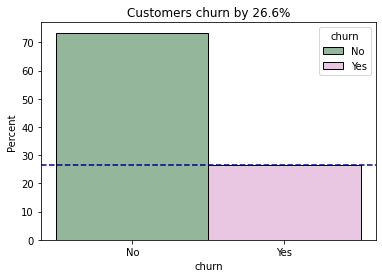

In [15]:
def get_churn_mean_bar(df):
    ''' This function takes in telco data frame and returns a histoplot that
    graphs the percentage of Telco customer who have churn'''
   
    c_percent = round(df.churn.value_counts(normalize=True)[1],3)* 100
    plt.title(f'Customers churn by {c_percent}%')
    sns.histplot(data =df, x='churn',stat='percent',hue='churn', palette='cubehelix')
    col_mean= round(df.churn.value_counts(normalize=True)[1],3)* 100
    plt.axhline(col_mean, label = 'Churn Rate',color='darkblue',linestyle='dashed')
   
    plt.show();
get_churn_mean_bar(train)

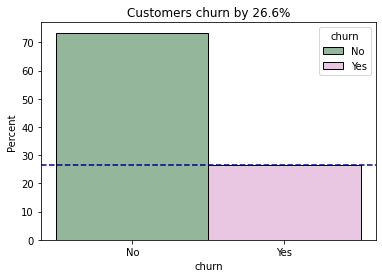

In [16]:
get_churn_mean_bar(train)

In [17]:
train.churn.value_counts(normalize=True)[1]

0.2656845313690627

### It appears that about 26% of telco customers churn.

# Baseline

In [18]:
#Find Baseline
train.churn.value_counts()
#Baseline is 0, customer did not chur

No     2891
Yes    1046
Name: churn, dtype: int64

In [19]:
#Baseline Accuracy
baseline = (train.churn == 'No').mean()
baseline

0.7343154686309372

# Does having a high monthly charge affect churn?

### I appears that monthly charges has some bearing on customer churn. Customers who have less monthly charges appear to have stayed with Telco.


In [20]:
train.monthly_charges.describe()

count    3937.000000
mean       64.805131
std        30.294804
min        18.250000
25%        34.700000
50%        70.250000
75%        90.300000
max       118.650000
Name: monthly_charges, dtype: float64

<AxesSubplot:title={'center':'Monthly Charges vs Churn'}, xlabel='monthly_charges', ylabel='Count'>

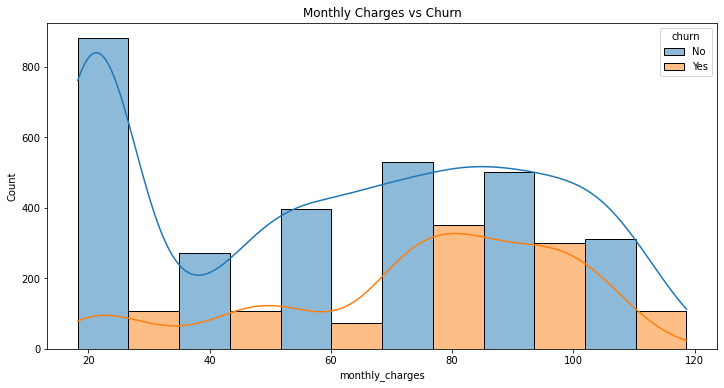

In [21]:
plt.figure(figsize=(12,6))
plt.title('Monthly Charges vs Churn')
sns.histplot(x='monthly_charges', data=train, hue='churn',multiple='dodge', kde= True, bins = 6)

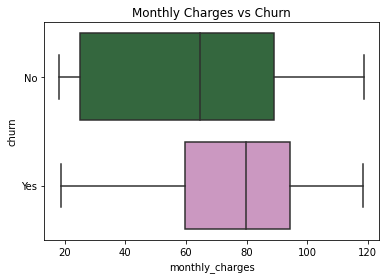

In [22]:
def get_monthly_charges(df):
    plt.title('Monthly Charges vs Churn')
    sns.boxplot(x=df.monthly_charges, y=df.churn,
                whis=np.inf, palette='cubehelix'
               )
get_monthly_charges(train)

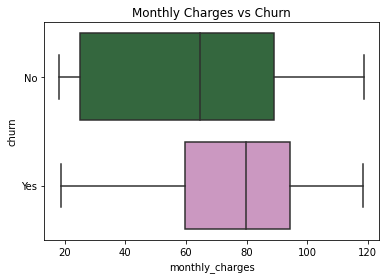

In [23]:
get_monthly_charges(train)

### Stat Test T-test

In [24]:
train.churn.value_counts()

No     2891
Yes    1046
Name: churn, dtype: int64

In [25]:
train[train.churn == 'Yes']

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_No phone service,multiple_lines_Yes,online_security_No,online_security_No internet service,online_security_Yes,online_backup_No,online_backup_No internet service,online_backup_Yes,device_protection_No,device_protection_No internet service,device_protection_Yes,tech_support_No,tech_support_No internet service,tech_support_Yes,streaming_tv_No,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_No,paperless_billing_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6992,Female,0,No,No,14,Yes,Yes,No,No,Yes,No,No,No,Yes,80.45,1072.00,Yes,Month-to-month,Fiber optic,Electronic check,1,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
6845,Male,0,Yes,Yes,29,Yes,No,No,No,No,No,No,No,Yes,70.75,1974.80,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
3171,Female,0,No,No,16,Yes,Yes,No,No,No,No,No,No,No,72.65,1194.30,Yes,Month-to-month,Fiber optic,Electronic check,1,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2375,Male,0,Yes,Yes,55,Yes,No,Yes,Yes,No,Yes,No,No,No,57.55,3046.40,Yes,Two year,DSL,Bank transfer (automatic),0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0
4551,Male,0,Yes,Yes,1,Yes,No,No,No,No,No,No,No,Yes,68.50,68.50,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,Female,0,No,No,3,Yes,Yes,No,No,No,No,No,No,No,74.40,215.80,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),1,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0
2194,Female,0,Yes,No,6,Yes,No,No,No,No,Yes,No,No,Yes,49.15,270.80,Yes,Month-to-month,DSL,Electronic check,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0
659,Male,0,No,No,32,Yes,No,No,No,No,Yes,Yes,Yes,Yes,96.20,3183.40,Yes,Month-to-month,Fiber optic,Electronic check,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0
3359,Male,0,Yes,No,59,Yes,Yes,No,No,Yes,No,Yes,Yes,Yes,99.50,5961.10,Yes,One year,Fiber optic,Bank transfer (automatic),0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0


In [26]:
subset_churn =train[train.churn == 1]
subset_notchurn = train[train.churn == 0]

    # # stats Levene test - returns p value. small p-value means unequal variances
stat, pval =stats.levene(subset_churn.monthly_charges, subset_notchurn.monthly_charges)
stat, pval

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

In [27]:
'''
Hypothesis 
Does monthly charges have a relationship with churn? 

Variables:
* monthly charges (continuous)
* churn(discrete)

Test: T-test two tail one sample scipy.stats.ttest_ind

$H_0$: Mean tenure of Telco customers who churn == mean tenure of Telco customers who do not churn.

$H_a$: Tean tenure of Telco customers who churn != mean tenure of Telco customers who do not churn.
'''

subset_churn =train[train.churn=='Yes']
subset_notchurn = train[train.churn =='No']

# # stats Levene test - returns p value. small p-value means unequal variances
stat, pval =stats.levene(subset_churn.monthly_charges, subset_notchurn.monthly_charges)


# high p-value suggests that the populations have equal variances

if pval < 0.05:
    print('inequal variance ==> set equl_var to False')
pval

alpha = 0.05

t_stat, p_val = stats.ttest_ind(subset_churn.monthly_charges, subset_notchurn.monthly_charges, equal_var = False)
print(f' t-stat:{stat}')
print(f' p-value:{pval}')

if pval/2 < 0.05:
    print('we can reject H0 ')
    
print(f'''
Because the p-value ({p_val}) is less than alpha value ({alpha}), we reject the null hypothesis''')

inequal variance ==> set equl_var to False
 t-stat:221.89598777895102
 p-value:7.315880114496924e-49
we can reject H0 

Because the p-value (2.460130776937842e-43) is less than alpha value (0.05), we reject the null hypothesis


In [28]:
subset_churn.shape

(1046, 61)

In [29]:
def get_ttest_monthly_charges(df):
    
    # create two independent sample group of customers: churn and not churn.
    subset_churn =df[df.churn=='Yes']
    subset_notchurn = df[df.churn =='No']

    # # stats Levene test - returns p value. small p-value means unequal variances
    stat, pval =stats.levene(subset_churn.monthly_charges, subset_notchurn.monthly_charges)


    # high p-value suggests that the populations have equal variances
    if pval < 0.05:
        variance = True
    else:
        variance = False

 
    alpha = 0.05

    t_stat, p_val = stats.ttest_ind(subset_churn.monthly_charges, subset_notchurn.monthly_charges, equal_var = True,random_state=123)
    t_stat = t_stat.round(4)
    p_val = p_val.round(4)
    print(f' t-stat:{t_stat}')
    print(f' p-value:{p_val}')

   

get_ttest_monthly_charges(train)

 t-stat:12.5961
 p-value:0.0


### REject null hypothesis there is significant difference between the means of of monthly charges of those who churn vs those who do not churn

#  Do Senior Citizens churn more than non-Senior Citizens?

In [32]:
sub_issenior = train[train.senior_citizen== 1]
sub_notsenior = train[train.senior_citizen == 0]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


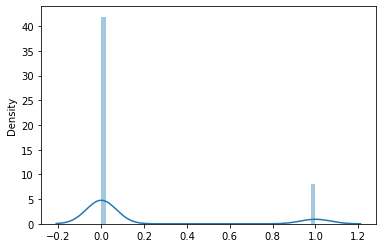

In [33]:
sns.distplot(x=train.senior_citizen,norm_hist=True,);

In [34]:
sub_issenior.describe()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_No phone service,multiple_lines_Yes,online_security_No,online_security_No internet service,online_security_Yes,online_backup_No,online_backup_No internet service,online_backup_Yes,device_protection_No,device_protection_No internet service,device_protection_Yes,tech_support_No,tech_support_No internet service,tech_support_Yes,streaming_tv_No,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_No,paperless_billing_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
count,635.0,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,1.0,33.470866,80.295591,2873.479685,0.513386,0.486614,0.494488,0.505512,0.913386,0.086614,0.086614,0.913386,0.329134,0.086614,0.584252,0.708661,0.039370,0.251969,0.533858,0.039370,0.426772,0.538583,0.039370,0.422047,0.729134,0.039370,0.231496,0.456693,0.039370,0.503937,0.423622,0.039370,0.537008,0.218898,0.781102,0.699213,0.179528,0.121260,0.239370,0.721260,0.039370,0.207874,0.207874,0.510236,0.074016
std,0.0,24.362736,23.316690,2406.294046,0.500215,0.500215,0.500364,0.500364,0.281491,0.281491,0.281491,0.281491,0.470269,0.281491,0.493239,0.454737,0.194627,0.434486,0.499246,0.194627,0.494998,0.498902,0.194627,0.494275,0.444757,0.194627,0.422121,0.498514,0.194627,0.500379,0.494522,0.194627,0.499022,0.413825,0.413825,0.458962,0.384096,0.326686,0.427035,0.448733,0.194627,0.406106,0.406106,0.500289,0.262003
min,1.0,1.000000,19.300000,19.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,10.000000,70.200000,635.350000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,31.000000,84.950000,2401.050000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.0,56.500000,97.875000,4779.575000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.0,72.000000,117.450000,8443.700000,1.000

In [35]:
sub_notsenior.churn.value_counts(normalize= True)

No     0.765294
Yes    0.234706
Name: churn, dtype: float64

In [36]:
sub_notsenior.churn.value_counts(normalize= True)

No     0.765294
Yes    0.234706
Name: churn, dtype: float64

In [37]:
melted_fan['perc'] =  melted_fan.groupby('variable')['value'].apply(lambda x:100*x/x.sum())
sns.barplot(x="value", y="variable", hue="Gender", 
                  data=melted_fan, ci=None)

NameError: name 'melted_fan' is not defined

In [38]:
sub_issenior.churn.value_counts(normalize = True)

No     0.573228
Yes    0.426772
Name: churn, dtype: float64

In [39]:
sns.barplot(x='senior_citizen', y="churn", hue="churn", 
                  data=melted_fan, ci=None)

NameError: name 'melted_fan' is not defined

<BarContainer object of 2 artists>

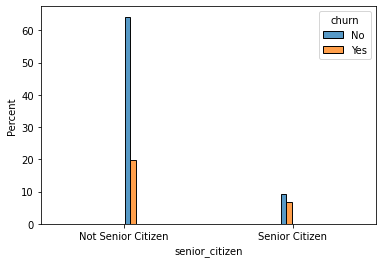

In [40]:
fig, ax = plt.subplots()
ax =sns.histplot(data = train, x= train.senior_citizen, stat="percent", multiple="dodge", shrink=.8, hue='churn')
ax.bar(['Not Senior Citizen', 'Senior Citizen'],0)


# sns.histplot(data = train, x=train.senior_citizen == 0, stat="percent")

<AxesSubplot:xlabel='senior_citizen', ylabel='Percent'>

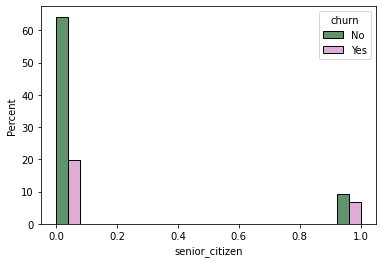

In [41]:
sns.histplot(data =train, cbar=True,x='senior_citizen',stat='percent',hue='churn', palette='cubehelix',multiple='dodge')


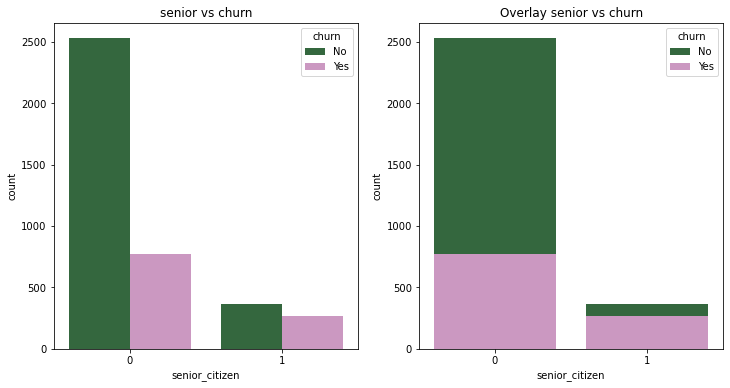

In [55]:
def get_bar_senior(df):
    plt.figure(figsize=(12,6))


    plt.subplot(1,2,1)
    plt.title('senior vs churn')
    sns.countplot(x=df.senior_citizen, data=train, hue = 'churn',palette='cubehelix')


    plt.subplot(1,2,2)
    plt.title('Overlay senior vs churn')
    sns.countplot(x=df.senior_citizen, data=train, hue = 'churn',dodge=False,palette='cubehelix')
    plt.show()
get_bar_senior(train)

### Stats Test Chi2 test

Do customers who are consider seniors churn more than customers who are not seniors?

Variables:

    * seniors (discrete)
    * churn (discrete)
    
Test: chi^2

$H_0$: There is **no** relationship between a customers with senior status and churn.

$H_a$: There is a relationship between a customers senior status and churn.

In [49]:
def get_chi2_senior(df):    
    # Chi-Square test to compare two categorical variables (senior citizen status, churn)

    alpha = 0.05

    # Setup a crosstab of observed 
    observed = pd.crosstab(df.senior_citizen==1, train.churn)

    chi2, p, degf, expected = stats.chi2_contingency(observed)

    chi2 = chi2.round(4)
    p = p.round(4)
    print(f' t-stat:{chi2}')
    print(f' p-value:{p}')
    
get_chi2_senior(train)

 t-stat:99.7192
 p-value:0.0


In [47]:
    # Chi-Square test to compare two categorical variables (senior citizen status, churn)

    alpha = 0.05

    # Setup a crosstab of observed 
    observed = pd.crosstab(train.senior_citizen==1, train.churn)

    chi2, p, degf, expected = stats.chi2_contingency(observed)

    if p < alpha:
        print("Reject the null hypothesis")

    else:
        print("Fail to reject the null")
        print("Insufficient evidence to reject the null")
    p,chi2

Reject the null hypothesis


(1.7561315684822695e-23, 99.71917005784367)

### Since we reject the null hypethesis there seems an significant association between customers who are senior citizens and churn.

# Does tenure affect churn?

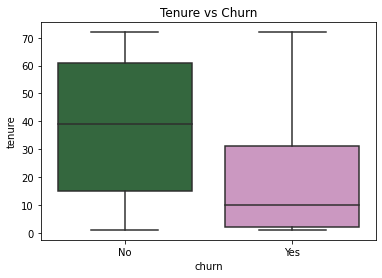

In [61]:
def get_boxplot_tenure(df):    
    plt.title('Tenure vs Churn')
    sns.boxplot(y=df.tenure, x=df.churn,palette='cubehelix',whis=np.inf);
get_boxplot_tenure(train)

<AxesSubplot:title={'center':'Tenure vs Churn'}, xlabel='churn', ylabel='tenure'>

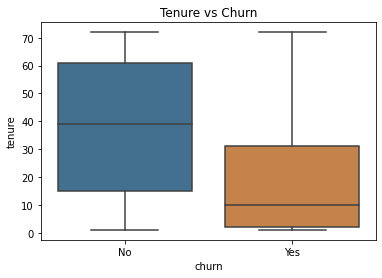

In [53]:
plt.title('Tenure vs Churn')
sns.boxplot(y=train.tenure, x=train.churn,saturation=.5,palette=''
            whis=np.inf
           )

### Stats Test T-test

In [87]:
'''
Hypothesis 
Does tenure have a relationship with churn? 

Variables:
* tenure (continuous)
* churn(discrete)

Test: T-test two tail one sample scipy.stats.ttest_ind

$H_0$: Mean tenure of Telco customers who churn == mean tenure of Telco customers who do not churn.

$H_a$: Tean tenure of Telco customers who churn != mean tenure of Telco customers who do not churn.
'''
subset_churn =train[train.churn=='Yes']
subset_notchurn = train[train.churn =='No']

# # stats Levene test - returns p value. small p-value means unequal variances
stats.levene(subset_churn.tenure, subset_notchurn.tenure)

# high p-value suggests that the populations have equal variances

if pval < 0.05:
    print('inequal variance ==> set equl_var to False')
else:
    print('False')
pval

alpha = 0.05

t_stat, p_val = stats.ttest_ind(subset_churn.tenure, subset_notchurn.tenure, equal_var = False,random_state=123)

print(f' t-stat:{t_stat}')
print(f' p-value:{p_val}')

if pval < 0.05:
    print('we can reject H0 ')
    
print(f'''
Because the p-value ({p_val}) is less than alpha value ({alpha}), we reject the null hypothesis''')

inequal variance ==> set equl_var to False
 t-stat:-25.770004822356352
 p-value:2.352878533952399e-128
we can reject H0 

Because the p-value (2.352878533952399e-128) is less than alpha value (0.05), we reject the null hypothesis


In [90]:
def get_ttest_tenure(df):
    
    # create two independent sample group of customers: churn and not churn.
    subset_churn =df[df.churn=='Yes']
    subset_notchurn = df[df.churn =='No']

    # # stats Levene test - returns p value. small p-value means unequal variances
    stat, pval =stats.levene(subset_churn.tenure, subset_notchurn.tenure)


    # high p-value suggests that the populations have equal variances
    if pval < 0.05:
        variance = False
        print('False')
    else:
        variance = True
        print('True')

 
    alpha = 0.05

    t_stat, p_val = stats.ttest_ind(subset_churn.tenure, subset_notchurn.tenure, equal_var = variance,random_state=123)
    #t_stat = t_stat.round(4)
    #p_val = p_val.round(4)
    print(f' t-stat:{t_stat}')
    print(f' p-value:{p_val}')


In [91]:
get_ttest_tenure(train)

False
 t-stat:-25.770004822356352
 p-value:2.352878533952399e-128


### Since we reject the null hypothesis there appears to be a significant difference in the tenure means of customers who churn and those who do not churn

# Does the contract type of customer affect churn?

<AxesSubplot:title={'center':'Contract Type vs Churn'}, xlabel='contract_type', ylabel='count'>

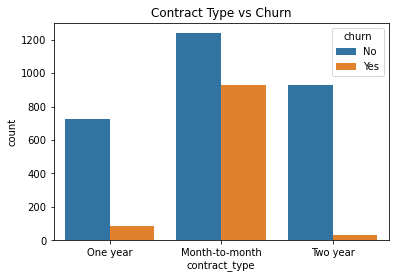

In [92]:
plt.title('Contract Type vs Churn')
sns.countplot(x=train.contract_type, data=train, hue = 'churn')


<AxesSubplot:xlabel='contract_type', ylabel='Percent'>

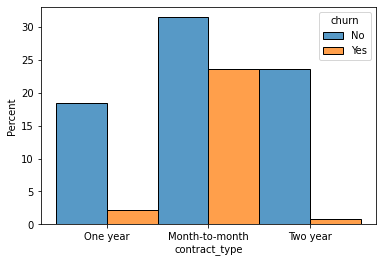

In [93]:
sns.histplot(data = train, x=train.contract_type, stat="percent", hue = 'churn', multiple = 'dodge')

In [ ]:
train.contract_type.value_counts()

In [ ]:
pd.crosstab(train.contract_type, train.churn)

### Stats TEST Chi2

In [ ]:
# Chi-Square test to compare two categorical variables (Contract type vs Churn)

alpha = 0.05

# Setup a crosstab of observed 
observed = pd.crosstab(train.contract_type, train.churn)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis")
    
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

### There appears to be a significant association between contract type and churn

# Do Senior Citizens pay more monthly charges that non Senior Citizens?

In [ ]:
plt.title('High monthly charges Drive Senior Citizens to Churn')
sns.barplot(data= train, x='senior_citizen', y='monthly_charges', hue = 'churn')

Hypothesis for Senior citizens and Monthly charges
Do customers who are consider seniors pay more monthly charges than customers who are not seniors? 

Variables:
* seniors (discrete)
* month charges(continuous)

Test: two sample, one tail, scipy.stats.ttest_ind

$H_0$: The mean monthly charges for senior citizens <= to the mean monthly charges of non senior citizens.

$H_a$: The mean monthly charges for senior citizens <= to the mean monthly charges of non senior citizens.

In [ ]:
total_charges_seniors = train[train.senior_citizen==1].total_charges
total_charges_nonseniors = train[train.senior_citizen==0].total_charges

In [ ]:
total_charges_seniors.var(),total_charges_nonseniors.var()

In [ ]:
# # stats Levene test - returns p value. small p-value means unequal variances
stat, pval = stats.levene(total_charges_seniors, total_charges_nonseniors)

# high p-value suggests that the populations have equal variances

if pval < 0.05:
    print('inequal variance ==> set equal_var to False')
pval

In [ ]:
alpha = 0.05

t_stat, p_val = stats.ttest_ind(total_charges_seniors, total_charges_nonseniors, equal_var = False)
print(f' t-stat:{stat}')
print(f' p-value:{pval}')

if pval/2 < 0.05:
    print('we can reject H0 ')
    
print(f'''
Because the p-value ({p_val}) is less than alpha value ({alpha}), we reject the null hypothesis''')

### Summary:
### Since we reject the null hypothesis, there seems to be significant findings that senior citizens on average do pay more Monthly Charges than non senior citizens.m

# Does gender influence churn?

In [ ]:
plt.title('Gender Vs Churn')
sns.countplot(x=train.gender, data=train, hue = 'churn')

plt.legend()
plt.show()

There does not seem to be a relationhip between churn and gender

### Stats Test Chi2

In [ ]:
'''
Hypothesis 
Gender vs churn

Variables:
* gender(discrete)
* churn(discrete)

Test: 

$H_0$: There is **no** relationship between a customers and tenure.

$H_a$: There is a relationship between a customers and tenure.
'''
    
print (pd.crosstab(train.contract_type, train.churn))

# Chi-Square test to compare two categorical variables (Sex and Survival)


alpha = 0.05

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.gender, train.churn)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis")
    
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

WE fail to reject the null hypothesis so threre is no association between gender and churn

### It does not appear like gender has and influence on churn

# Does partner affect the churn?

In [ ]:
plt.title('Partner Vs Churn')
sns.countplot(x=train.partner, data=train, hue = 'churn')

plt.legend()
plt.show()

### There seems to be a relationship between partner and churn

# Stats Test Chi2

In [ ]:
'''
Hypothesis 
partner vs churn

Variables:
* partner(discrete)
* churn(discrete)

Test: 

$H_0$: There is **no** relationship between a customers and partner

$H_a$: There is a relationship between a customers and partner.
'''
    
print (pd.crosstab(train.partner, train.churn))

# Chi-Square test to compare two categorical variables (Sex and Survival)


alpha = 0.05

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.partner, train.churn)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis")
    
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

### WE reject the null hypothesis so there is an association between partner anc churn

# Exploration Summary
* Monthly Charges is a driver of churn
* Senior Citizen status is a driver of churn
* Tenure is a driver of churn
* Contract type is a driver of churn
* Partner is a driver of churn
* Gender is not a driver of churn



# Features that will be included in my model

* Monthly charges  has a significant statistical relationship to churn
* Senior Citizen  has a significant statistical relationship to churn
* Tenure  has a significant statistical relationship to churn
* Contract type has a significan statistical relationship to churn
* Partner  has a significant statistical relationship to churn

# Features that will not be included in my model

* Gender did not have a statistical significant relationship to churn.
* Other features have unknow significance to churn at the moment
    * given more time to I would determined significance to churn.

# Modeling

* Accuracy is the metric use in the models
* Churn customers makeup 26.5% of the data 
* by guessing non-churn for every customer one could achieve an accuracy of 73.5%
* 73.5% will be the baseline accuracy I use for this project 

* I will be evaluating models developed using four different model types and various hyperparameter configurations

* Models will be evaluated on train and validate data

* The model that performs the best will then be evaluated on test data

In [ ]:
train.columns.to_list()

In [ ]:
def model_prep(train,validate,test):
    
        # drop unused columns 
        features = ['monthly_charges','senior_citizen','tenure','partner_No','partner_Yes','churn','contract_type_Month-to-month','contract_type_One year','contract_type_Two year']

        train = train[features]
        validate = validate[features]
        test = test[features]
        
       

        
        #seperate target
        
         
        x_train = train.drop(columns=['churn'])
        y_train = train.churn

        x_validate = validate.drop(columns=['churn'])
        y_validate = validate.churn

        x_test = test.drop(columns=['churn'])
        y_test = test.churn
        
        # Convert binary categorical targer variable to numeric
        y_train.churn= train.churn.map({'Yes': 1, 'No': 0})
        y_validate.churn = validate.churn.map({'Yes': 1, 'No': 0})
        y_test.churn = test.churn.map({'Yes': 1, 'No': 0})
        
       

        return x_train,y_train,x_validate,y_validate, x_test, y_test

In [ ]:
# prep data for modeling
x_train,y_train,x_validate,y_validate, x_test, y_test = model_prep(train,validate,test)

In [ ]:
x_train.shape, x_validate.shape, x_test.shape

# Decision Tree

In [ ]:
DecisionTreeClassifier?


In [ ]:

metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(x_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(x_train, y_train)
    
    out_of_sample_accuracy = tree.score(x_validate, y_validate)

    output = {
        "i": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df_2 = pd.DataFrame(metrics)
df_2["difference"] = df_2.train_accuracy - df_2.validate_accuracy
df_2

In [ ]:
df_2[df_2.validate_accuracy > .77]

### Decision Tree Best Model

In [ ]:
# for decision tree the best model has  max_depth of 3.
# 3	0.789942	0.776659	0.01328
tree = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model (on train and only train)
tree = tree.fit(x_train, y_train)

In [ ]:
Accuracy of Decision Tree on train data is 0.789942
Accuracy of Decision Tree on validate data is 0.776659

In [ ]:
Decision Tree accuracy is about 

# Random Forest

In [ ]:
metrics=[]
for h in range(10,0,-1):
   
    print(f'max depth {h}')
    
    for i in range(1, 21):
  
    # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)
    
    # Fit the model (on train and only train)
        random_forest.fit(x_train, y_train)
        
         # Use the model
    # We'll evaluate the model's performance on train, first
        in_sample_accuracy = random_forest.score(x_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(x_train)
        
        output = {
        "max_depth": h,
        "min_samples_leaf": i,
        "train_accuracy": in_sample_accuracy,
        #"validate_accuracy": y_pred
    }

        metrics.append(output)
        
        df = pd.DataFrame(metrics)
df
  
 

In [ ]:
metrics=[]
for h in range(10,0,-1):
   
    print(f'max depth {h}')
    
    for i in range(1, 21):
  
    # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)
    
    # Fit the model (on train and only train)
        random_forest = random_forest.fit(x_train, y_train)
        
         # Use the model
    # We'll evaluate the model's performance on train, first
        in_sample_accuracy = random_forest.score(x_train, y_train)
        
    
        out_of_sample_accuracy = random_forest.score(x_validate, y_validate)


    # Use the model
    # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(x_train)
        
        output = {
        "max_depth": h,
        "min_samples_leaf": i,
        "train_accuracy": in_sample_accuracy,
         "validate_accuracy": out_of_sample_accuracy   
      
    }

        metrics.append(output)
        
        df_2 = pd.DataFrame(metrics)



        df_2["difference"] = df_2.train_accuracy - df_2.validate_accuracy
df_2

In [ ]:
df_2[df_2.validate_accuracy>.784]

### Best Model Random Forest

In [ ]:
#Random Forest best model 5	18	0.805690	0.784953	validate on Accuracy data0.020737
# Make the model
random_forest = RandomForestClassifier(max_depth=5, min_samples_leaf = 18 , random_state=123)
    
# Fit the model (on train and only train)
random_forest = random_forest.fit(x_train, y_train)

# KNN

In [ ]:
# iteration:
metrics = []

for i in range(1,10):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train, y_train)
    
    model_accuracies = {
        'train_score': round(clf.score(x_train, y_train), 2),
        'validate_score': round(clf.score(x_validate, y_validate), 2)}
    
    metrics.append(model_accuracies)
    df = pd.DataFrame(metrics)


df

In [ ]:
df.train_score-df.validate_score

# Best Model KNN

In [ ]:
#6	0.82	0.77 validate accuracy

clf = KNeighborsClassifier(n_neighbors=6)
clf.fit(x_train, y_train)

Accuracy of Decision Tree on train data is 0.6728988603988604
Accuracy of Decision Tree on validate data is 0.6722060656418779

* 

# Logistic Regression

In [ ]:
# Define the logistic regression model
logit = LogisticRegression(C=1, random_state=123)

In [ ]:
#  fit the model on train data 
logit.fit(x_train, y_train)

In [ ]:
y_pred = logit.predict(x_train)

# classification report for Model 2 using train data
print(classification_report(y_train, y_pred))


In [ ]:
y_p = logit.predict(x_validate)

# classification report for Model 2 using train data
print(classification_report(y_validate, y_p))

In [ ]:
# best model .78  on validate,
logit = LogisticRegression(C=1, random_state=123)

In [ ]:
# Define the logistic regression model
logit = LogisticRegression(C=1, solver='saga',random_state=123)
#  fit the model on train data usingfeatures 
logit.fit(x_train, y_train)

y_pred = logit.predict(x_train)

# classification report for Model 2 using train data
print(classification_report(y_train, y_pred))

y_p = logit.predict(x_validate)

# classification report for Model 2 using train data
print(classification_report(y_validate, y_p))